In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
import lime.lime_tabular
import lime.lime_tabular_mod
import matplotlib.pyplot as plt

import importlib
importlib.reload(lime.lime_tabular_mod)

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load iris dataset

In [2]:
iris_dataset = pd.read_csv(
    "../data/iris-classification/iris.data",
    names=[
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width",
        "label"
    ]).sample(frac=1)
iris_dataset

,sepal_length,sepal_width,petal_length,petal_width,label
116,6.5,3.0,5.5,1.8,Iris-virginica
38,4.4,3.0,1.3,0.2,Iris-setosa
57,4.9,2.4,3.3,1.0,Iris-versicolor
85,6.0,3.4,4.5,1.6,Iris-versicolor
7,5.0,3.4,1.5,0.2,Iris-setosa
...,...,...,...,...,...
22,4.6,3.6,1.0,0.2,Iris-setosa
117,7.7,3.8,6.7,2.2,Iris-virginica
113,5.7,2.5,5.0,2.0,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica


In [3]:
iris_dataset.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [4]:
iris_dataset.corr()

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.109369,0.871754,0.817954
sepal_width,-0.109369,1.000000,-0.420516,-0.356544
petal_length,0.871754,-0.420516,1.000000,0.962757
petal_width,0.817954,-0.356544,0.962757,1.000000


In [5]:
# encoder = OneHotEncoder(sparse=False)
# categories_transformed = encoder.fit_transform(iris_dataset[["label"]])
# encoder.categories_[0]

In [6]:
iris_dataset_transformed_labels = iris_dataset.copy()
iris_dataset_transformed_labels["iris_setosa"] = iris_dataset_transformed_labels["label"] == "Iris-setosa"
iris_dataset_transformed_labels["iris_versicolor"] = iris_dataset_transformed_labels["label"] == "Iris-versicolor"
iris_dataset_transformed_labels["iris_virginica"] = iris_dataset_transformed_labels["label"] == "Iris-virginica"
iris_dataset_transformed_labels.corr()

,sepal_length,sepal_width,petal_length,petal_width,iris_setosa,iris_versicolor,iris_virginica
sepal_length,1.000000,-0.109369,0.871754,0.817954,-0.717416,0.079396,0.638020
sepal_width,-0.109369,1.000000,-0.420516,-0.356544,0.595601,-0.464700,-0.130901
petal_length,0.871754,-0.420516,1.000000,0.962757,-0.922688,0.201587,0.721102
petal_width,0.817954,-0.356544,0.962757,1.000000,-0.887510,0.118376,0.769134
iris_setosa,-0.717416,0.595601,-0.922688,-0.887510,1.000000,-0.500000,-0.500000
iris_versicolor,0.079396,-0.464700,0.201587,0.118376,-0.500000,1.000000,-0.500000
iris_virginica,0.638020,-0.130901,0.721102,0.769134,-0.500000,-0.500000,1.000000


### Prepare dataset 

In [7]:
labels_column_name = "label"
train_set = iris_dataset.drop(columns=labels_column_name).values
train_labels = iris_dataset[labels_column_name].values
jackknife_idx = np.random.randint(0, train_set.shape[0])
test_set = train_set[[jackknife_idx], :]
test_labels = train_labels[[jackknife_idx]]


unique_labels = np.unique(train_labels)
attributes = iris_dataset.columns.tolist()
attributes.remove(labels_column_name)
unique_labels.sort()
attributes.sort()
print(f"Labels: {unique_labels}")
print(f"Attributes: {attributes}")

Labels: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
Attributes: ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']


In [8]:
random_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 42)
random_forest.fit(train_set, train_labels)

RandomForestClassifier(n_estimators=42)

In [9]:
result = random_forest.predict(test_set)
accuracy = sklearn.metrics.accuracy_score(test_labels, result)
print(f"Predicted: {result}. It's accuracy: {accuracy}")

Predicted: ['Iris-setosa']. It's accuracy: 1.0


### Use LIME to explain local prediction

In [10]:
explainer = lime.lime_tabular_mod.LimeTabularExplainerMod(
    train_set,
    feature_names = attributes,
    class_names = train_labels
)

Show probabilities for random instance (given by random forest on test dataset)

In [11]:
sample_idx = np.random.randint(low=0, high=test_set.shape[0])
instance = test_set[sample_idx]
probabilities = random_forest.predict_proba(instance.reshape(1,-1))[0,:]
probabilities_for_labels = {}
for label, probability in zip(random_forest.classes_, probabilities):
    probabilities_for_labels[label] = probability
print(probabilities_for_labels)
predicted_label_id = np.argmax(probabilities)

{'Iris-setosa': 1.0, 'Iris-versicolor': 0.0, 'Iris-virginica': 0.0}


Explain the instance

array([1., 0., 0.])

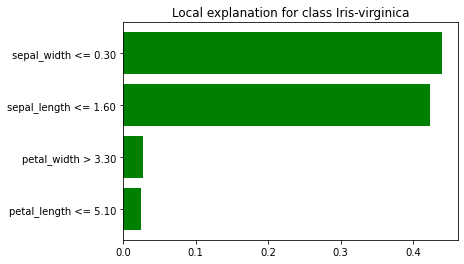

In [12]:
importlib.reload(lime.lime_tabular_mod)
explanation = explainer.explain_instance(
    instance,
    random_forest.predict_proba,
    num_features = 4,
    top_labels = 3
)
explanation.as_pyplot_figure(explanation.top_labels[0])
explanation.predict_proba   # probabilites from explained model

In [15]:
print(explanation.get_prediction_for_explained_model())
print(explanation.get_prediction_for_surrogate_model())
print(explanation.get_prediction_for_surrogate_model(normalized=True))


[1.0, 0.0, 0.0]
[0.972670468307731, 0.12065967936635397, -0.09333014767408476]
[0.5646720473163472, 0.2408644498381541, 0.19446350284549857]


In [16]:
top_features = explanation.as_map()[explanation.top_labels[0]]
top_features

[(3, 0.43929693233169964),
 (2, 0.42320106634493077),
 (1, 0.027013475991149324),
 (0, 0.025213435186338142)]

In [17]:
second_top_features = explanation.as_map()[explanation.top_labels[1]]
second_top_features

[(3, -0.2543069060019661),
 (2, -0.24450119586601005),
 (1, -0.023297738487906478),
 (0, -0.021696207166941744)]

In [18]:
explanation.as_map()

{1: [(3, -0.18499002632973355),
  (2, -0.17869987047892064),
  (1, -0.0037157375032428413),
  (0, -0.0035172280193963897)],
 2: [(3, -0.2543069060019661),
  (2, -0.24450119586601005),
  (1, -0.023297738487906478),
  (0, -0.021696207166941744)],
 0: [(3, 0.43929693233169964),
  (2, 0.42320106634493077),
  (1, 0.027013475991149324),
  (0, 0.025213435186338142)]}

In [19]:
explainer.discretizer.names

{0: ['petal_length <= 5.10',
  '5.10 < petal_length <= 5.80',
  '5.80 < petal_length <= 6.40',
  'petal_length > 6.40'],
 1: ['petal_width <= 2.80',
  '2.80 < petal_width <= 3.00',
  '3.00 < petal_width <= 3.30',
  'petal_width > 3.30'],
 2: ['sepal_length <= 1.60',
  '1.60 < sepal_length <= 4.35',
  '4.35 < sepal_length <= 5.10',
  'sepal_length > 5.10'],
 3: ['sepal_width <= 0.30',
  '0.30 < sepal_width <= 1.30',
  '1.30 < sepal_width <= 1.80',
  'sepal_width > 1.80']}

In [20]:
explainer.discretizer.maxs

{0: [5.1, 5.8, 6.4, 7.9],
 1: [2.8, 3.0, 3.3, 4.4],
 2: [1.6, 4.35, 5.1, 6.9],
 3: [0.3, 1.3, 1.8, 2.5]}

Update some attributes to see if probabilities would change

In [21]:
top_features = explanation.as_map()[predicted_label_id]
top_features

[(3, 0.43929693233169964),
 (2, 0.42320106634493077),
 (1, 0.027013475991149324),
 (0, 0.025213435186338142)]

In [22]:
instance

array([5. , 3.6, 1.4, 0.2])

In [23]:
instance_to_experiment_with = instance.copy()
print('Probabilities before:', random_forest.predict_proba(instance_to_experiment_with.reshape(1,-1)))
instance_to_experiment_with[most_important_feature_id] = 2.0
print('Probabilities after:', random_forest.predict_proba(instance_to_experiment_with.reshape(1,-1)))

Probabilities before: [[1. 0. 0.]]


NameError: name 'most_important_feature_id' is not defined

Explain changed instance to see the changes

In [24]:
# explainer.discretizer.bins()  # TODO need to modify src to get suggested change

In [ ]:
# exp = explainer.explain_instance(
#     instance_to_experiment_with,
#     random_forest.predict_proba,
#     num_features = 4,
#     top_labels = 3
# )
# exp.as_pyplot_figure(predicted_label_id)
# exp.predict_proba